# Some grammar case studies

## Imports and useful functions

In [1]:
try:
    # in colab
    import google.colab
    print('In colab, downloading LOTlib3')
    !git clone https://github.com/thelogicalgrammar/LOTlib3
    !pip install ColabTurtlePlus
    !pip install cairosvg
except:
    # not in colab
    print('Not in colab!')

from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plt
import re
from ColabTurtlePlus import Turtle as t
import ColabTurtlePlus as ctp
import IPython

import cairosvg
import io
from PIL import Image, ImageFilter
from scipy.signal import sawtooth
from pprint import pprint

Not in colab!
Put clearscreen() as the first line in a cell (after the import command) to re-run turtle commands in the cell


In [2]:
from LOTlib3.Miscellaneous import q, random, logsumexp
from LOTlib3.Grammar import Grammar
from LOTlib3.DataAndObjects import FunctionData, Obj
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.Eval import primitive
from LOTlib3.Miscellaneous import qq
from LOTlib3.TopN import TopN
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler

In [3]:
def normalize(arr):
    # Transform the array so that it sums to 1
    return arr / np.sum(arr)


def apply_rule(match, grammar):
    """
    Accepts both PCFGs (where the keys of grammar
    are lists of tuples (unnormalized prob, right hand side)
    and CFGs (where the keys are lists of right hand side strings.
    """
    match_txt = grammar[match.group(0)]
    try:
        # if PCFG
        probs, subs = zip(*match_txt)
    except ValueError:
        # if CFG
        subs = match_txt
        probs = [1]*len(subs)
    sub = choice(subs, p=normalize(probs))
    return sub


def complete(sentence, grammar):
    # if there are still '<' that means there are still nonterminals
    while '<' in sentence:
        # substitute the first nonterminal applying 
        # one of the rules in the grammar
        sentence = re.sub(
            # Greedy search of an expression between
            # angle brackets.
            '<(.*?)>', 
            lambda match: apply_rule(match, grammar), 
            sentence
        )
    return sentence

## Shapes

### Some shape-specific functions

In [2325]:
def get_svg(screen=None):
        """Shows the SVG code for the image to the screen."""
        if screen is None:
            screen = t.Screen()
        header = ("""<svg width="{w}" height="{h}" viewBox="0 0 {w} {h}" xmlns="http://www.w3.org/2000/svg">\n""").format(
            w=screen.window_size[0],
            h=screen.window_size[1]) 
        header += ("""<rect width="100%" height="100%" style="fill:{fillcolor};stroke:{kolor};stroke-width:1" />\n""").format(
            fillcolor=screen.background_color,
            kolor=screen.border_color)
        # lines = screen._svg_drawlines_string.replace("/>","/>\n")
        image = screen._generateSvgLines().replace("/>","/>\n") 
        output = header + image + "</svg>"
        return output

def blur_img(img, p_noise=0.):
    # whether to switch pixel or not
    # noise should be maximal when p_noise is 1
    p_noise = p_noise/2
    salt_and_pepper = np.where(
        np.random.choice(
            [0,1],
            size=img.shape,
            p=[1-p_noise, p_noise]
        ),
        img,
        1-img
    )
    return salt_and_pepper

def svg_to_img(svg, p_noise=0):
    """
    Load an SVG file and return image in Numpy array.
    Modified version of function from:
    https://stackoverflow.com/questions/55440483/
    how-can-i-optimize-the-palette-image-size-with-pil
    /55442505#55442505
    """
    # Make memory buffer
    mem = io.BytesIO()
    # Convert SVG to PNG in memory
    cairosvg.svg2png(
        bytestring=svg, 
        write_to=mem,
    )
    # Convert PNG to Pillow object
    img = np.array(Image.open(mem))
    # Remove greys and normalize in [0,1]
    # and take only first value of 3 RGB 
    # (They're all the same since original image
    # is in shades of grey)
    img = np.round(img[:,:,0]/img.max())
    return blur_img(
        np.array(img), 
        p_noise
    )

### A grammar of shapes

Based on these movements, we can define a grammar that produces series of instructions and just use the meanings defined by the Turtle library:

\begin{align}
\langle\text{START}\rangle 
&\rightarrow 
\text{chain}(\langle\text{DRAWING}\rangle) \\
\langle\text{DRAWING}\rangle 
&\rightarrow 
\langle\text{MOVEMENT}\rangle,\langle\text{DRAWING}\rangle \\
&\rightarrow 
\epsilon
\\
\langle\text{MOVEMENT}\rangle 
&\rightarrow  
\text{forward}(\langle\text{DISTANCE}\rangle) \\
&\rightarrow 
\text{backward}(\langle\text{DISTANCE}\rangle) \\
&\rightarrow 
\text{right}(\langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{left}(\langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{circle}(\langle\text{DISTANCE}\rangle, \langle\text{ANGLE}\rangle) \\
&\rightarrow 
\text{goto}(0,0)
\\
\langle\text{DISTANCE}\rangle 
&\rightarrow 50 \mid 100 \mid 120
\\
\langle\text{ANGLE}\rangle 
&\rightarrow 30 \mid 60 \mid 90 \mid 170
\end{align}

In [2077]:
grammar = {
    '<start>': [(1,'chain(<drawing>)')],
    # always start with a drawing
    '<drawing>': [
        # a drawing can include a movement 
        # follows by a drawing (recursive!)
        (8, '<movement>,<drawing>'),
        # at some point the drawing ends
        (1, ''),
    ],
    # a movement is basically a single instruction
    # so a drawing consists of a series of movements
    # Movements have two types of parameters,
    # namely: angles and distances
    '<movement>': [
        (1, 'forward_(<distance>)'),
        (1, 'backward_(<distance>)'),
        (1, 'right_(<angle>)'),
        (1, 'left_(<angle>)'),
        (1, 'circle_(<distance>,<angle>)'),
        (1, 'goto_(0,0)')
    ],
    # hand-specify some distances
    '<distance>': [
        (1, '10'),
        (1, '20'),
        (1, '50'),
    ],
    # hand-specify some angles
    '<angle>': [
        (1, '30'),
        (1, '60'),
        (1, '90'),
        (1, '170')
    ]
}

### Turtle semantics

Instead of defining meanings ourselves, we can rely on an already existing library. For instance, consider Python's 'turtle' library. The idea is very simple: Imagine a little turtle that moves around the screen according to certain instructions, and as it moves around it traces a line. Instructions are things like 'move forward', 'go around some of a circle', etc.

Each sentence in our grammar gets interpreted by the turtle library into a shape.

Here's an example to show you the syntax:

In [2078]:
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
t.forward(100); t.circle(50,90); t.forward(100)

In [2079]:
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(13)
t.forward(10); t.circle(20,60); t.right(90); t.forward(100); t.goto(0,0)

### Generating from a grammar and interpreting

In [2080]:
@primitive
def forward_(x): return lambda : t.forward(x)

@primitive
def backward_(x): return lambda : t.backward(x)

@primitive
def right_(x): return lambda : t.right(x)

@primitive
def left_(x): return lambda : t.left(x)

@primitive
def circle_(x,y): return lambda : t.circle(x,y)

@primitive
def goto_(x,y): return lambda : t.goto(x,y)

@primitive
def chain(*args, speed=0):
    # args is a list of functions
    t.initializeTurtle(window=(100,100))
    t.hideturtle()
    t.color('black')
    t.speed(speed)
    for f in args:
        f()
    screen = t.Screen()
    return get_svg(screen)

Try to run this multiple times and note that sometimes the result is just empty or a straight line, and sometimes it is some interesting complex shapes:

chain(circle_(20,30),circle_(50,30),left_(170),forward_(10),forward_(20),backward_(20),goto_(0,0),circle_(50,30),goto_(0,0),circle_(50,170),backward_(10),forward_(20),right_(30),right_(30),backward_(50),circle_(20,90),circle_(10,60),circle_(10,30),right_(90),left_(90),circle_(50,30),backward_(10),right_(90),left_(60),backward_(50),left_(90),right_(90),backward_(50),)
chain(left_(60),forward_(10),backward_(50),left_(30),circle_(20,170),backward_(50),goto_(0,0),goto_(0,0),goto_(0,0),forward_(10),left_(30),backward_(20),right_(30),circle_(10,90),right_(30),right_(170),forward_(20),circle_(20,170),left_(90),backward_(10),left_(90),left_(60),circle_(20,60),backward_(10),left_(90),right_(90),circle_(10,90),)
chain(goto_(0,0),left_(170),backward_(50),right_(60),goto_(0,0),right_(60),circle_(10,60),circle_(20,90),circle_(20,170),forward_(20),right_(60),forward_(50),forward_(10),left_(30),forward_(10),backward_(10),right_(90),left_(60),left_(90),forward_(50),circle_(10,90),left_(60),forward_(50

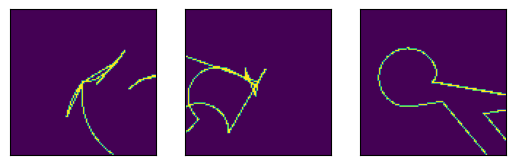

In [2324]:
n_imgs = 3

imgs = []
for i in range(n_imgs):
    # define the 'central' part of the instructions
    instructions = complete('<start>', grammar)

    print(instructions)
    # add some needed scaffolding around the 
    # sentence produced by the grammar
    svg_representation = eval(instructions)
    imgs.append(
        svg_to_img(
            svg_representation,
        )
    )

fig, axes = plt.subplots(
    1,
    len(imgs), 
    sharey=True, 
    sharex=True
)

for ax, im in zip(axes, imgs):
    ax.imshow(im)

axes[0].set_xticks([])
axes[0].set_yticks([])
fig.savefig('imgs/shapes_examples.png')

The point here is: each sentence in our grammar is a shape.

If we take the LoT hypothesis seriously, we can then think that shape concepts (squares, triangles, etc.) are encoded at the cognitive level as sentences in the geometric fragment of the LoT.

> Practical note: Sometimes we do not want to see the full animation, but rather just the final product. In that case, we can set speed at 0 and then call `done`, as follows:

```
t.clearscreen()
t.initializeTurtle()
t.hideturtle()
t.color('black')
t.speed(0)
for i in range(20): {instructions}
t.done()
```

### Going from a shape to a noisy observation

chain(circle_(50,90),left_(60),left_(30),backward_(20),right_(90),right_(170),circle_(50,60),backward_(10),circle_(50,60),right_(90),goto_(0,0),forward_(20),circle_(50,60),backward_(10),goto_(0,0),backward_(50),) 

chain(goto_(0,0),forward_(10),right_(30),right_(170),circle_(50,30),circle_(50,90),left_(170),goto_(0,0),goto_(0,0),left_(170),right_(170),) 

chain(right_(90),backward_(20),goto_(0,0),right_(170),circle_(50,170),circle_(20,90),right_(170),goto_(0,0),circle_(10,30),left_(90),goto_(0,0),left_(30),forward_(50),right_(90),right_(170),goto_(0,0),backward_(10),forward_(20),forward_(50),right_(170),) 



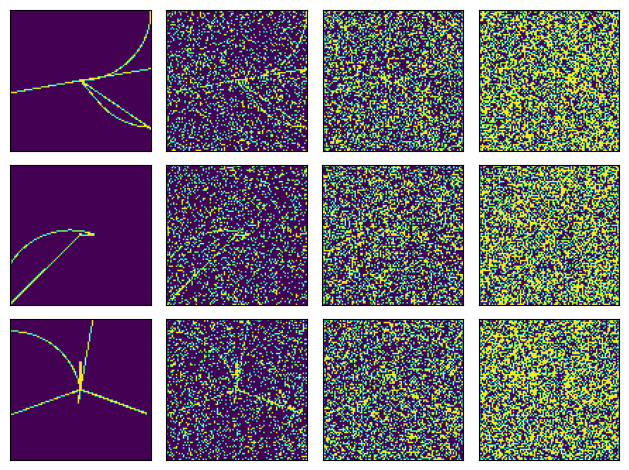

In [2339]:
n_shapes=3
degrees_noise = [0, 0.4, 0.7, 1.0]

images = []
for i in range(n_shapes):
    instructions1 = complete('<start>', grammar)
    print(instructions1, "\n")
    svg_representation = eval(instructions1) 
    for d in degrees_noise:
        img = svg_to_img(
            svg_representation,
            d
        )
        images.append(img)

fig, axes = plt.subplots(
    n_shapes,
    len(degrees_noise), 
    sharex=True, 
    sharey=True
)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for ax, im in zip(axes.flatten(), images):
    ax.imshow(im)

fig.tight_layout()
fig.savefig('imgs/noisy_vs_sharp.png', dpi=300)

### Learning a shape from an image

In [2340]:
##### define a hypothesis
class MyHypothesis(LOTHypothesis):
    
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(
            self, 
            grammar=lot_grammar, 
            display="lambda: %s", 
            **kwargs
        )

    def compute_single_likelihood(self, datum):
        # eval expression of current hypothesis 
        # to get an svg image, then get pixels
        img_clear = svg_to_img(
            self(),
            # level of noise
            p_noise=0
        )
        
        # total logprob
        total_loglik = np.where(
            img_clear==datum.output,
            np.log(1-datum.noise_level),
            np.log(datum.noise_level)
        ).sum()
        
        return total_loglik
        
    def display():
        svg_representation = self()
        img_clear = svg_to_img(
            svg_representation,
            # degree of blurriness
            0
        )
        plt.imshow(img_clear)

print("Defined a hypothesis class")

Defined a hypothesis class


In [2341]:
##### define a LOTlib3 grammar
lot_grammar = Grammar(start='<start>')
for nonterminal, substitutions in grammar.items():
    for weight, subt in substitutions:

        to_substitute = []
        def capture_and_replace(match):
            to_substitute.append(match.group(0))
            return '%s'
        # replace nonterminals with %s
        subt_replaced = re.sub(
            r'<[a-z]*>', 
            capture_and_replace, 
            subt
        )
        # add a rule to the grammar
        print(subt_replaced)
        lot_grammar.add_rule(
            nonterminal, 
            subt_replaced, 
            to_substitute if len(to_substitute)>0 else None, 
            weight
        )

print("Defined the grammar!")

chain(%s)
%s,%s

forward_(%s)
backward_(%s)
right_(%s)
left_(%s)
circle_(%s,%s)
goto_(0,0)
10
20
50
30
60
90
170
Defined the grammar!


In [2342]:
# define the 'central' part of the instructions
instructions = complete('<start>', grammar)

chain(circle_(50,90),backward_(10),right_(90),right_(170),right_(30),forward_(10),right_(90),left_(170),goto_(0,0),circle_(20,60),right_(30),goto_(0,0),goto_(0,0),goto_(0,0),backward_(20),forward_(20),goto_(0,0),circle_(10,60),circle_(20,60),circle_(50,60),left_(170),goto_(0,0),right_(60),left_(30),)


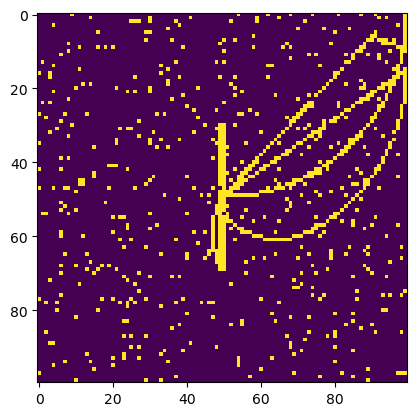

In [2344]:
noise_level = 0.1
print(instructions)
# add some needed scaffolding around the 
# sentence produced by the grammar
svg_representation = eval(instructions)
img_noisy = svg_to_img(
    svg_representation,
    p_noise=noise_level
)

plt.imshow(img_noisy)

We have defined an interpreted grammar for ideal, abstract shapes. Imagine now the following situations. We _see_ some image and we are trying to learn what shape (in our shape grammar) it is. The problem is that the images are blurry, so we are not quite sure: Each image could have been generated by different shapes, to varying extents!

In [2345]:
h = MyHypothesis()

##### Define Data
data = [ 
    FunctionData(
        input=[], 
        output=img_noisy, 
        noise_level=noise_level
    )
]

In [2346]:
# store the top N
tn = TopN(
    N=1000
) 

print("Defined the data")

##### Run inference
h = MyHypothesis()

print("Running inference...")

Defined the data
Running inference...


In [2347]:
for i, h in enumerate(MetropolisHastingsSampler(h, data, steps=40000)):
    tn.add(h)
    if i%100==0:
        print(i, end=', ')

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800,

In [2352]:
hs = tn.get_all(sorted=True)
z = logsumexp([h.posterior_score for h in hs])
pps_im = np.zeros(true_img.shape)
for h in hs:
    p = np.exp(h.posterior_score - z)
    print(np.round(p,3), end=', ')
    try:
        svg_rep = h()
        h_img = svg_to_img(svg_rep)
        print(np.unique(h_img), end=', ')
        print(h)
        pps_im = pps_im + h_img*p
    except:
        pass

0.0, 0.0, [0. 1.], lambda: chain(left_(90),left_(30),right_(170),backward_(50),backward_(20),)
0.0, [0. 1.], lambda: chain(goto_(0,0),left_(30),right_(170),backward_(50),backward_(20),)
0.0, [0. 1.], lambda: chain(goto_(0,0),left_(30),right_(170),backward_(50),forward_(50),)
0.0, [0. 1.], lambda: chain(goto_(0,0),left_(30),right_(170),right_(170),forward_(50),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(170),right_(170),goto_(0,0),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(170),right_(30),goto_(0,0),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(170),left_(60),goto_(0,0),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(170),goto_(0,0),goto_(0,0),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(170),)
0.0, [0.], lambda: chain(goto_(0,0),left_(30),right_(90),)
0.0, [0.], lambda: chain(goto_(0,0),left_(60),right_(90),)
0.0, [0.], lambda: chain(left_(30),)
0.0, [0.], lambda: chain()
0.0, [0. 1.], lambda: chain(circle_(50,30),forward_(10),right_(90)

In [2353]:
true_img = svg_to_img(
    svg_representation,
    p_noise=0
)

best_str = tn.best()
best_img = svg_to_img(best_str())

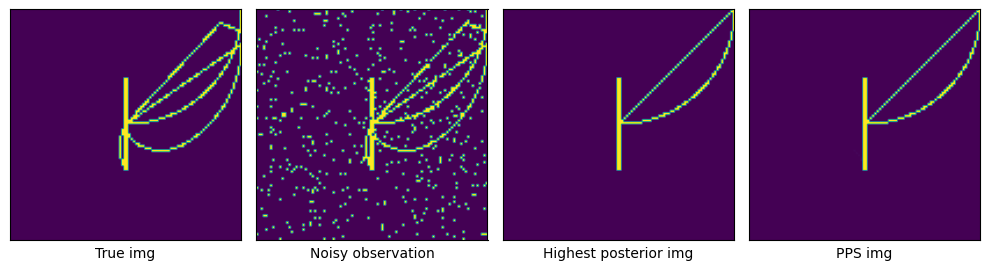

In [2372]:
fig, (ax_true, ax_observation, ax_best, ax_pps) = plt.subplots(
    1,4,
    sharex=True,
    sharey=True,
    figsize=(10,3)
)

kwargs = {
    'vmin': 0,
    'vmax': 1,
}

ax_true.imshow(true_img)
ax_true.set_xlabel('True img')
ax_observation.imshow(img_noisy, **kwargs)
ax_observation.set_xlabel('Noisy observation')
ax_best.imshow(best_img, **kwargs)
ax_best.set_xlabel((
    'Highest posterior img'
    # '\n'+best_str.__str__()'
))
ax_pps.imshow(pps_im, **kwargs)

ax_pps.set_xlabel('PPS img')
ax_true.set_xticks([])
ax_true.set_yticks([])

# fig.suptitle('True: '+instructions)
fig.tight_layout()
fig.savefig('imgs/inference.png')

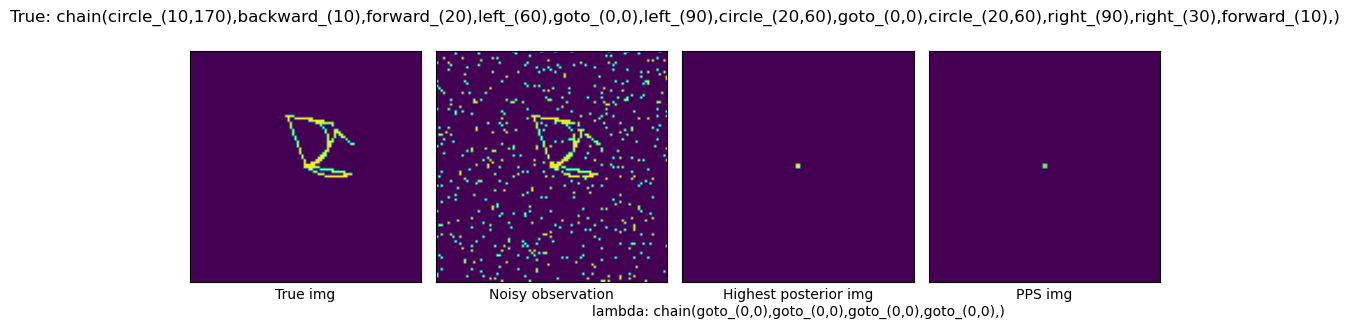

In [2290]:
fig, (ax_true, ax_observation, ax_best, ax_pps) = plt.subplots(
    1,4,
    sharex=True,
    sharey=True,
    figsize=(10,3)
)

kwargs = {
    'vmin': 0,
    'vmax': 1,
}

ax_true.imshow(true_img)
ax_true.set_xlabel('True img')
ax_observation.imshow(img_noisy, **kwargs)
ax_observation.set_xlabel('Noisy observation')
ax_best.imshow(best_img, **kwargs)
ax_best.set_xlabel('Highest posterior img\n'+best_str.__str__())
ax_pps.imshow(pps_im, **kwargs)

ax_pps.set_xlabel('PPS img')
ax_true.set_xticks([])
ax_true.set_yticks([])

fig.suptitle('True: '+instructions)
fig.tight_layout()

### Things to try

> Grammar
> - How to make the shapes more round?
> - How to make them more "spiky"?

> Likelihood
> - Can you think of other kinds of noise? 
> - How would they affect inference?

## A music grammar

### Defining the grammar

Another fascinating domain of interest for cognitive science is that of sounds. Let's think of what a simple grammar for sounds could be like. Let's define a very simple grammar of music which can nonetheless encode many possible sounds:

\begin{align}
\langle\text{TUNE}\rangle 
&\rightarrow 
\langle\text{NOTE}\rangle 
\\
&\rightarrow 
\text{successive}(\langle\text{TUNE}\rangle,\langle\text{TUNE}\rangle) 
\\
&\rightarrow 
\text{melt}(\langle\text{TUNE}\rangle,\langle\text{TUNE}\rangle) 
\\
\langle\text{NOTE}\rangle 
&\rightarrow 
\text{defineNote}(\langle\text{FREQ}\rangle,\langle\text{TIME}\rangle)
\\
\langle\text{TIME}\rangle 
&\rightarrow 
0.1 \mid 0.2 \mid 0.3
\\
\langle\text{FREQ}\rangle 
&\rightarrow 
\text{A} \mid \text{Bb} \mid \text{B} \mid \text{C} \mid \text{Db} \mid \text{D} \mid \text{Eb} \mid \text{E} \mid \text{F} \mid \text{Gb} \mid \text{G} \mid \text{Ab}
\end{align}

Define each note in an octave, so we can call them by name as described in the grammar:

In [4]:
freqs = {
    'A': 220,
    # 'Bb': 233.08,
    # 'B': 246.94,
    'C': 261.63,
    # 'Db': 277.18,
    'D': 293.66,
    # 'Eb': 311.13,
    'E': 329.63,
    # 'F': 349.23,
    # 'Gb': 369.99,
    'G': 392.00,
    # 'Ab': 415.30,
}

In [57]:
soundGrammar = {
    '<tune>': [
        (3, '<note>'),
        (1, 'successive(<tune>, <tune>)'),
        (1, 'melt(<tune>, <tune>)')
    ],
    '<note>': [
        (1, "defineNote('<freq>', <time>)")
    ],
    '<freq>': [(1,x) for x in freqs.keys()],
    '<time>': [
        (1, '0.3'), 
        (1, '0.6'), 
        (1, '1.'),
    ]
}

In [58]:
pprint(soundGrammar)

{'<freq>': [(1, 'A'), (1, 'C'), (1, 'D'), (1, 'E'), (1, 'G')],
 '<note>': [(1, "defineNote('<freq>', <time>)")],
 '<time>': [(1, '0.3'), (1, '0.6'), (1, '1.')],
 '<tune>': [(3, '<note>'),
            (1, 'successive(<tune>, <tune>)'),
            (1, 'melt(<tune>, <tune>)')]}


### Semantics: From sentence to sounds

In [8]:
# define rate (don't worry about this!)
fs = 44100

We are going to need a way of defining notes given a frequency:

In [9]:
@primitive
def defineNote(frequency, seconds, fs=44100, harmonic_strength=0.1):

    if isinstance(frequency, str):
        frequency = freqs[frequency]
    # jitter frequency slightly to reduce strident interference
    # frequency = np.random.rand()*3 + frequency
    
    # seconds*sample_rate steps 
    # between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)

    # Harmonics
    harmonics = np.zeros_like(t)
    for i in range(2, 11):  # Adding the first 10 harmonics
        harmonics += (
            np.sin(frequency * i * t * 2 * np.pi)
            # sawtooth(2 * np.pi * i * frequency * t, 0.5)
            * np.exp(
                -i * harmonic_strength
            )
        )

    # Fundamental frequency
    note = np.sin(frequency * t * 2 * np.pi) + harmonics
    # note = sawtooth(2 * np.pi * frequency * t, 0.5)

    # # Create ADSR envelope
    # attack_time = 0.5
    # decay_time = 0.1
    # sustain_level = 1.
    # release_time = 0.1

    # total_frames = len(t)
    # attack_frames = int(total_frames * attack_time)
    # decay_frames = int(total_frames * decay_time)
    # sustain_frames = int(total_frames * (1.0 - attack_time - decay_time - release_time))
    # release_frames = total_frames - attack_frames - decay_frames - sustain_frames

    # envelope = np.concatenate([
    #     np.linspace(0, 1, attack_frames),  # Attack
    #     np.linspace(1, sustain_level, decay_frames),  # Decay
    #     np.full(sustain_frames, sustain_level),  # Sustain
    #     np.linspace(sustain_level, 0, release_frames)  # Release
    # ])

    # # Apply envelope
    # note *= envelope

    return note

We'll also need a way of melting two notes, i.e. playing them together:

In [10]:
@primitive
def melt(note1, note2):
    # if they are of different lengths,
    # pad the shorter one with 0s
    diff = len(note1) - len(note2)
    if diff < 0:
        note1 = np.concatenate((
            note1,
            np.zeros(-diff, dtype=int)
        ))
    elif diff > 0:
        note2 = np.concatenate((
            note2,
            np.zeros(diff, dtype=int)
        ))

    combined = note1+note2
    audio = combined * (2**15 - 1) / np.max(np.abs(combined))
    audio = audio.astype(np.int16)
    
    return audio

And a way of appending one note to another one:

In [11]:
@primitive
def successive(note1, note2):
    return np.concatenate((note1, note2))

And finally collect all the primitive meanings we defined in a single dictionary, so that we can use it with `interpret` to get the meaning of each sentence produced by the grammar:

In [12]:
interpret = {
    **freqs,
    'defineNote': defineNote,
    'melt': melt,
    'successive': successive 
}

### Creating "music"

Now we can play "music":

In [12]:
simple_A = defineNote(220, 1, harmonic_strength=0.1)

IPython.display.Audio(
    # put note or notes here!
    simple_A, 
    rate=fs, 
    autoplay=True
)

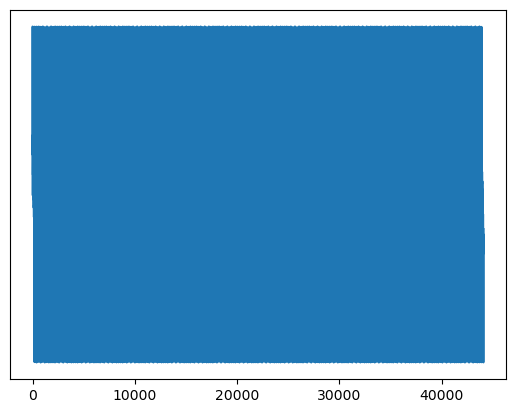

In [2425]:
plt.plot(simple_A)
plt.yticks([])
plt.savefig('imgs/simple_A.png')

Test the function:

In [2377]:
melted = melt(
    defineNote(freqs['A'], 1),
    defineNote(freqs['D'], 2)
)

IPython.display.Audio(
    melted, 
    rate=fs, 
    autoplay=True
)

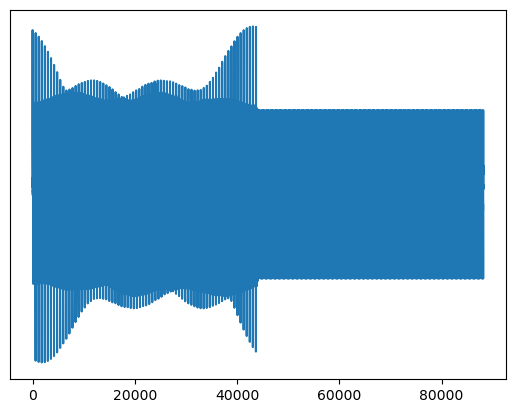

In [2426]:
plt.plot(melted)
plt.yticks([])
plt.savefig('imgs/example_melt.png')

Run this until you get something long that looks interesting! As in the geometric example above, some productions are very simple while others are very messy and complicated.

In [16]:
tune = complete('<tune>', soundGrammar)
pprint(tune)

("successive(defineNote('A', 1.), successive(defineNote('E', 0.3), "
 "successive(defineNote('A', 0.3), melt(defineNote('D', 0.6), defineNote('E', "
 '1.)))))')


In [17]:
IPython.display.Audio(
    # put note or notes here!
    eval(tune, interpret), 
    rate=fs, 
    autoplay=True
)

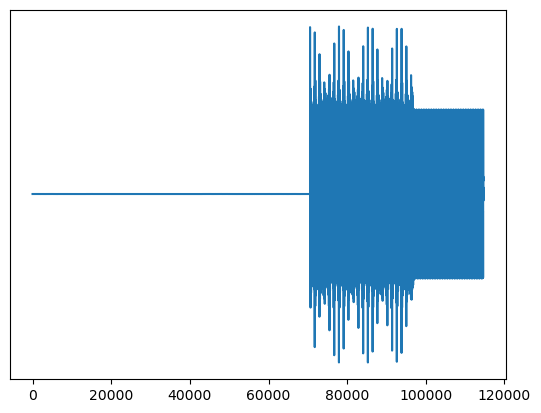

In [18]:
plt.plot(eval(tune))
plt.yticks([])
plt.savefig('imgs/complex_example.png')

This is not going to sound very good, possibly because the grammar is not encoding any of the interesting structure we like in music. 

### Creating a noisy observation

In [2430]:
tune = complete('<tune>', soundGrammar)
pprint(tune)
sound = eval(tune, interpret)
sigma = np.max(sound)/3
print(sigma)
noisy_sound = sound + np.random.normal(scale=sigma, size=sound.shape)

("melt(defineNote('A', 0.3), successive(melt(defineNote('G', 0.3), "
 "melt(successive(defineNote('A', 0.6), defineNote('A', 1.)), "
 "melt(successive(melt(defineNote('D', 0.6), successive(defineNote('C', 0.6), "
 "melt(successive(defineNote('C', 0.3), defineNote('D', 0.3)), defineNote('E', "
 "1.)))), defineNote('D', 0.6)), successive(defineNote('E', 0.6), "
 "defineNote('C', 1.))))), melt(successive(defineNote('E', 0.3), "
 "defineNote('C', 1.)), melt(defineNote('C', 1.), melt(defineNote('A', 0.6), "
 "defineNote('E', 0.3))))))")
10922.333333333334


In [2484]:
print(tune)

successive(defineNote('G', 0.6), successive(defineNote('D', 0.6), successive(successive(successive(successive(defineNote('G', 0.3), melt(melt(defineNote('A', 0.3), successive(defineNote('C', 1.), defineNote('D', 0.3))), defineNote('G', 0.6))), defineNote('E', 0.6)), defineNote('E', 0.6)), successive(melt(melt(defineNote('E', 0.6), successive(defineNote('C', 0.3), defineNote('D', 1.))), defineNote('G', 0.3)), defineNote('G', 0.3)))))


In [2431]:
IPython.display.Audio(
    # put note or notes here!
    sound, 
    rate=fs, 
    autoplay=True
)

In [2432]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound, 
    rate=fs, 
    autoplay=True
)

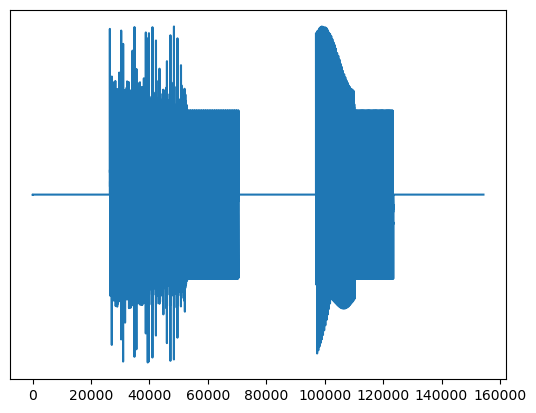

In [2435]:
plt.plot(sound)
plt.yticks([])
plt.savefig('imgs/clean_example.png')

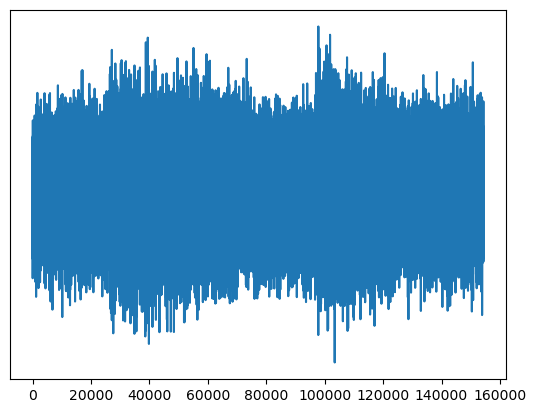

In [2436]:
plt.plot(noisy_sound)
plt.yticks([])
plt.savefig('imgs/noisy_example.png')

In [ ]:
tune0 = complete('<tune>', soundGrammar)
tune1 = complete('<tune>', soundGrammar)
tune2 = complete('<tune>', soundGrammar)

In [196]:
print(tune0, '\n')
print(tune1, '\n')
print(tune2, '\n')

defineNote('C', 0.3) 

melt(defineNote('C', 0.3), successive(defineNote('G', 1.), defineNote('E', 0.6))) 

successive(melt(defineNote('C', 0.3), melt(successive(successive(defineNote('D', 0.3), defineNote('D', 1.)), defineNote('C', 0.3)), defineNote('E', 0.6))), defineNote('C', 0.3)) 



In [206]:
sound0 = eval(tune0, interpret)
sound1 = eval(tune1, interpret)
sound2 = eval(tune2, interpret)

sigma0 = np.max(sound0)/3
sigma1 = np.max(sound1)/3
sigma2 = np.max(sound2)/3

# make them all equally long
max_length = np.max([sound0.shape, sound1.shape, sound2.shape])

In [207]:
# diff from max length
sound0 = np.concatenate([
    sound0,
    np.zeros(np.abs(sound0.shape-max_length))
])

sound1 = np.concatenate([
    sound1,
    np.zeros(np.abs(sound1.shape-max_length))
])

sound2 = np.concatenate([
    sound2,
    np.zeros(np.abs(sound2.shape-max_length))
])

In [208]:
noisy_sound0 = sound0 + np.random.normal(scale=sigma0, size=sound0.shape)
noisy_sound1 = sound1 + np.random.normal(scale=sigma1, size=sound1.shape)
noisy_sound2 = sound2 + np.random.normal(scale=sigma2, size=sound2.shape)

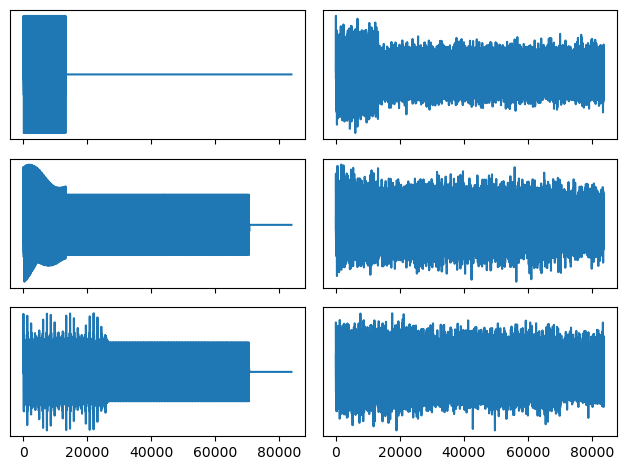

In [209]:
fig, axes = plt.subplots(3,2,sharex=True)
((ax1, ax2, ax3), (noise_ax1, noise_ax2, noise_ax3)) = axes.T
ax1.plot(sound0)
noise_ax1.plot(noisy_sound0)
ax2.plot(sound1)
noise_ax2.plot(noisy_sound1)
ax3.plot(sound2)
noise_ax3.plot(noisy_sound2)

for ax in axes.flatten():
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('imgs/prior_lik_compare.png')

In [211]:
IPython.display.Audio(
    # put note or notes here!
    sound0, 
    rate=fs, 
    autoplay=True
)

In [212]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound0, 
    rate=fs, 
    autoplay=True
)

In [213]:
IPython.display.Audio(
    # put note or notes here!
    sound1, 
    rate=fs, 
    autoplay=True
)

In [214]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound1, 
    rate=fs, 
    autoplay=True
)

In [215]:
IPython.display.Audio(
    # put note or notes here!
    sound2, 
    rate=fs, 
    autoplay=True
)

In [216]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound2, 
    rate=fs, 
    autoplay=True
)

### Learning in an LoT

In [59]:
##### define a LOTlib3 grammar
lot_sound_grammar = Grammar(start='<tune>')
for nonterminal, substitutions in soundGrammar.items():
    for weight, subt in substitutions:
        to_substitute = []
        def capture_and_replace(match):
            to_substitute.append(match.group(0))
            return '%s'
        # replace nonterminals with %s
        subt_replaced = re.sub(
            r'<[a-z]*>', 
            capture_and_replace, 
            subt
        )
        # add a rule to the grammar
        print(subt_replaced)
        lot_sound_grammar.add_rule(
            nonterminal, 
            subt_replaced, 
            to_substitute if len(to_substitute)>0 else None, 
            weight
        )

print("Defined the grammar!")

%s
successive(%s, %s)
melt(%s, %s)
defineNote('%s', %s)
A
C
D
E
G
0.3
0.6
1.
Defined the grammar!


In [60]:
lot_sound_grammar.display_rules()

<tune> -> %s['<note>']	w/ p=3.0
<tune> -> successive(%s, %s)['<tune>', '<tune>']	w/ p=1.0
<tune> -> melt(%s, %s)['<tune>', '<tune>']	w/ p=1.0
<note> -> defineNote('%s', %s)['<freq>', '<time>']	w/ p=1.0
<freq> -> A	w/ p=1.0
<freq> -> C	w/ p=1.0
<freq> -> D	w/ p=1.0
<freq> -> E	w/ p=1.0
<freq> -> G	w/ p=1.0
<time> -> 0.3	w/ p=1.0
<time> -> 0.6	w/ p=1.0
<time> -> 1.	w/ p=1.0


In [61]:
def log_prob_normal(x, mu=0, sigma=1):
    """
    Returns the log-probability of x under a normal distribution
    with mean mu and standard deviation sigma.
    """
    return -0.5 * np.log(2 * np.pi) - np.log(sigma) - ((x - mu) ** 2) / (2 * sigma ** 2)

In [130]:
##### define a hypothesis
class MusicHypothesis(LOTHypothesis):
    
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(
            self, 
            grammar=lot_sound_grammar, 
            display="lambda : %s", 
            **kwargs
        )
        self.sigma=sigma

    def compute_single_likelihood(self, datum):

        self_sound = self()
        obs_sound = datum.output

        # diff is positive when h is
        # longer than observation
        diff = len(self_sound) - len(obs_sound)
        if diff < 0:
            # self_sound = np.concatenate((
            #     self_sound,
            #     np.zeros(-diff, dtype=int)
            # ))
            # if observation is longer,
            # it can't be the right h
            return -np.inf
        elif diff > 0:
            obs_sound = np.concatenate((
                obs_sound,
                np.zeros(diff, dtype=int)
            ))
        logprob = log_prob_normal(
            self_sound - obs_sound,
            sigma=datum.sigma
        ).sum()
        
        return logprob

print("Defined a hypothesis class")

Defined a hypothesis class


In [139]:
tune = complete('<tune>', soundGrammar)
pprint(tune)

# evaluate the tune into soundwaves
sound = eval(tune, interpret)

# get a noise in the order of magnitude we want
sigma = np.max(sound)/1

noisy_sound = (
    sound 
    + np.random.normal(scale=sigma, size=sound.shape)
)

("melt(defineNote('G', 0.3), successive(successive(defineNote('A', 0.6), "
 "defineNote('C', 1.)), defineNote('E', 1.)))")


In [171]:
print(tune)

melt(defineNote('G', 0.3), successive(successive(defineNote('A', 0.6), defineNote('C', 1.)), defineNote('E', 1.)))


In [168]:
IPython.display.Audio(
    # put note or notes here!
    sound, 
    rate=fs, 
    autoplay=True
)

In [141]:
IPython.display.Audio(
    # put note or notes here!
    noisy_sound, 
    rate=fs, 
    autoplay=True
)

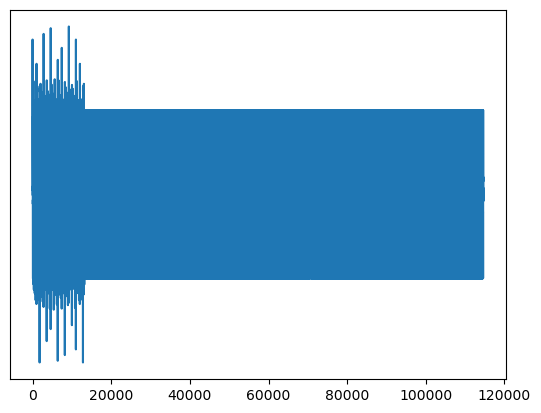

In [169]:
plt.plot(sound)
plt.yticks([])
plt.savefig('imgs/clean_example_learning.png')

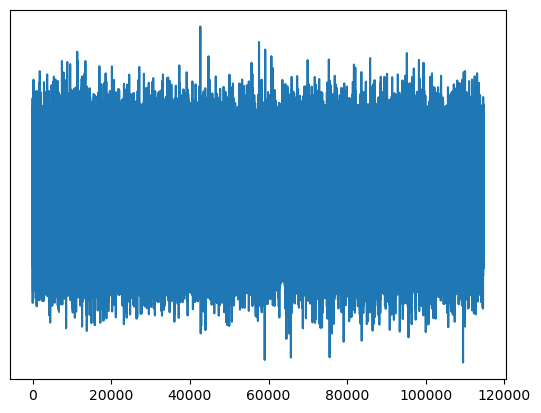

In [172]:
plt.plot(noisy_sound)
plt.yticks([])
plt.savefig('imgs/noisy_example_learning.png')

In [144]:
##### Define Data
data = [ 
    FunctionData(
        input=[], 
        output=noisy_sound, 
        sigma=sigma
    )
]

In [145]:
# store the top N
tn = TopN(
    N=30
) 

##### Run inference
h = MusicHypothesis()

In [146]:
import sys
sys.setrecursionlimit(1500)

In [147]:
print("Running inference...")

for i, h in enumerate(MetropolisHastingsSampler(h, data, steps=10000)):
    tn.add(h)
    if i%100==0:
        print(i, end=', ')

Running inference...
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 

In [148]:
best_one = tn.best()

In [152]:
IPython.display.Audio(
    # put note or notes here!
    best_one(), 
    rate=fs, 
    autoplay=True
)

In [174]:
best_one

lambda : successive(successive(defineNote('A', 1.), defineNote('A', 1.)), defineNote('D', 0.6))

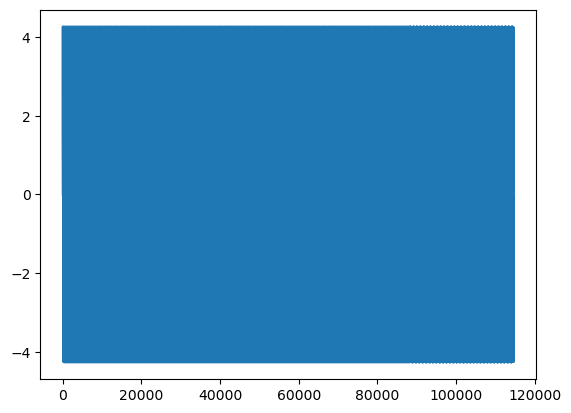

In [173]:
plt.plot(best_one())

In [166]:
IPython.display.Audio(
    # put note or notes here!
    sound, 
    rate=fs, 
    autoplay=True
)

In [155]:
for h in tn.get_all(sorted=True):
    print(np.exp(h.posterior_score), h.prior, h.likelihood, h)

0.0 -12.875503299472802 -1356873.3427921375 lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('C', 0.6))
0.0 -12.875503299472802 -1356873.3383733607 lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('G', 0.6))
0.0 -12.875503299472802 -1356873.3376659977 lambda : successive(successive(defineNote('G', 1.), defineNote('D', 1.)), defineNote('D', 0.6))
0.0 -12.875503299472802 -1356873.337366325 lambda : successive(successive(defineNote('C', 1.), defineNote('A', 1.)), defineNote('D', 0.6))
0.0 -12.875503299472802 -1356873.330359108 lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('D', 0.6))
0.0 -12.875503299472802 -1356873.3051245434 lambda : successive(successive(defineNote('A', 1.), defineNote('C', 1.)), defineNote('A', 0.6))
0.0 -12.875503299472802 -1356873.2931516496 lambda : successive(successive(defineNote('A', 1.), defineNote('C', 1.)), defineNote('E', 0.6))
0.0 -12.87550329947280

In [162]:
hs = tn.get_all(sorted=True)
z = logsumexp([h.posterior_score for h in hs])
pps_sound = np.zeros(sound.shape)
for h in hs:
    p = np.exp(h.posterior_score - z)
    try:
        h_sound = h()
        print(p)
        print(h, "\n")
        pps_sound = pps_sound + h_sound*p
    except:
        print('Raised error')

0.03131755710576977
lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('C', 0.6)) 

0.03145624859938691
lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('G', 0.6)) 

0.031478507457739266
lambda : successive(successive(defineNote('G', 1.), defineNote('D', 1.)), defineNote('D', 0.6)) 

0.03148794211737613
lambda : successive(successive(defineNote('C', 1.), defineNote('A', 1.)), defineNote('D', 0.6)) 

0.03170935981671909
lambda : successive(successive(defineNote('G', 1.), defineNote('A', 1.)), defineNote('D', 0.6)) 

0.032519713163564244
lambda : successive(successive(defineNote('A', 1.), defineNote('C', 1.)), defineNote('A', 0.6)) 

0.03291140841703552
lambda : successive(successive(defineNote('A', 1.), defineNote('C', 1.)), defineNote('E', 0.6)) 

0.03299081549347328
lambda : successive(successive(defineNote('A', 1.), defineNote('C', 1.)), defineNote('C', 0.6)) 

0.033037738400539765
lambda : successive(successive(de

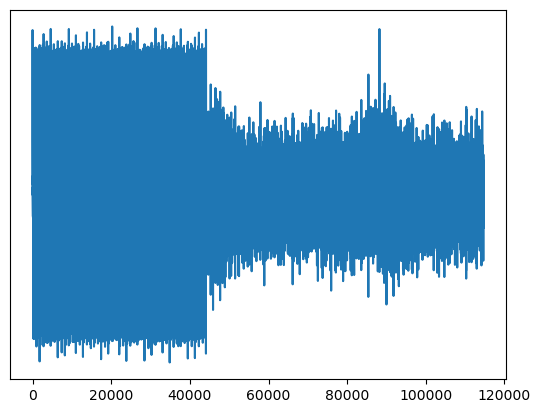

In [175]:
plt.plot(pps_sound)
plt.yticks([])
plt.savefig('imgs/pps_example_learning.png')

In [165]:
IPython.display.Audio(
    # put note or notes here!
    pps_sound, 
    rate=fs, 
    autoplay=True
)

In [94]:
tune

"melt(defineNote('A', 0.6), melt(melt(successive(defineNote('G', 0.6), melt(successive(defineNote('C', 0.6), defineNote('D', 1.)), successive(successive(defineNote('A', 0.3), defineNote('C', 0.3)), defineNote('C', 1.)))), melt(defineNote('G', 1.), defineNote('C', 1.))), successive(melt(defineNote('E', 0.3), defineNote('A', 1.)), defineNote('G', 0.6))))"

### Things to try

- How could we change the vibe to be more calm?
- How could we modify the grammar to make tunes less 'messy'?